## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_ve.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos      TRM  Precio Interno
0    2010-01-01    0.000000  2044.23        695125.0
1    2010-01-02    4.256365  2044.23        695125.0
2    2010-01-03    0.794545  2044.23        695125.0
3    2010-01-04    0.787899  2044.23        705000.0
4    2010-01-05    0.601027  2021.21        690000.0
...         ...         ...      ...             ...
3648 2019-12-27    4.003614  3281.40        995000.0
3649 2019-12-28    2.090121  3294.05        995000.0
3650 2019-12-29    0.539108  3294.05        995000.0
3651 2019-12-30    1.815513  3294.05        991000.0
3652 2019-12-31    1.871355  3277.14        975000.0

[3653 rows x 4 columns]

---

## Desarrollo del modelo RF

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(1093, 1)
(1093, 11)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.20357092058572393
MAE is : 0.31947701228649533
RMSE is : 0.45118834269706476
MAPE is : 15.599810312537791
Evaluation metric results:
MSE is : 0.977071088938979
MAE is : 0.7528236356862251
RMSE is : 0.9884690632179537
MAPE is : 41.2856595123185
(1093, 1)
(1093, 11)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19635184825125077
MAE is : 0.3219088797869446
RMSE is : 0.44311606634295125
MAPE is : 16.094361477862837
Evaluation metric results:
MSE is : 0.9952020772070166
MAE is : 0.7608092037447911
RMSE is : 0.9975981541718171
MAPE is : 41.903111501765814
(1093, 1)
(1093, 11)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.18996845697167744
MAE is : 0.31679157469352337
RMSE is : 0.435853710517276
MAPE is : 15.74755956310449
Evaluation metric results:
MSE is : 0.9802859283872953
MAE is : 0.756412042000098
RMSE is : 0.9900938987728868
MAPE is : 41.54864355289285
(1093, 1)
(1093, 11)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.18729476537380654
MAE is : 0.31714273407873234
RMSE is : 0.432775652473434
MAPE is : 15.79209673721762
Evaluation metric results:
MSE is : 0.9687306167703847
MAE is : 0.7505805829870348
RMSE is : 0.9842411375117303
MAPE is : 41.31682550675364
(1093, 1)
(1093, 11)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.1886462802009922
MAE is : 0.31691650662499793
RMSE is : 0.43433429544648233
MAPE is : 15.753143818018936
Evaluation metric results:
MSE is : 0.9719830958396605
MAE is : 0.7519666026663346
RMSE is : 0.9858920305183831
MAPE is : 41.44638502589959
(1091, 1)
(1091, 17)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19954679488727334
MAE is : 0.3254038796890293
RMSE is : 0.44670660940630075
MAPE is : 16.28878172684961
Evaluation metric results:
MSE is : 0.9944907718264323
MAE is : 0.7700127613288903
RMSE is : 0.9972415814768417
MAPE is : 43.30817886733896
(1091, 1)
(1091, 17)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19315347672278566
MAE is : 0.3210621379192142
RMSE is : 0.439492294270088
MAPE is : 16.022221578876575
Evaluation metric results:
MSE is : 0.9910760119150388
MAE is : 0.7685245165189545
RMSE is : 0.9955280065950123
MAPE is : 43.15949869853778
(1091, 1)
(1091, 17)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.1931161203142274
MAE is : 0.3206175997114194
RMSE is : 0.43944979271155354
MAPE is : 15.937587153203769
Evaluation metric results:
MSE is : 0.9760404137757437
MAE is : 0.761426446945164
RMSE is : 0.9879475764309277
MAPE is : 42.79164133972838
(1091, 1)
(1091, 17)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.18651197407128572
MAE is : 0.3175542367784466
RMSE is : 0.43187032089654614
MAPE is : 15.816709395473987
Evaluation metric results:
MSE is : 0.9806296341576866
MAE is : 0.764696879060758
RMSE is : 0.9902674558712341
MAPE is : 42.87501714211071
(1091, 1)
(1091, 17)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19041801651324428
MAE is : 0.319154881885062
RMSE is : 0.4363691287353452
MAPE is : 15.868150839089266
Evaluation metric results:
MSE is : 0.9793719117919161
MAE is : 0.7642669085825401
RMSE is : 0.9896322103650003
MAPE is : 42.887535594490856
(1089, 1)
(1089, 23)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.21419276629035422
MAE is : 0.32674628058544614
RMSE is : 0.4628096436877199
MAPE is : 16.095502094601354
Evaluation metric results:
MSE is : 1.0035483261780034
MAE is : 0.7671341323648835
RMSE is : 1.0017725920477178
MAPE is : 42.93374121130009


<ipython-input-5-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])
<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


(1089, 1)
(1089, 23)
len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19692730829956234
MAE is : 0.3207929175222555
RMSE is : 0.4437649245935987
MAPE is : 16.033999071656556
Evaluation metric results:
MSE is : 0.9999800827929358
MAE is : 0.7670583686039565
RMSE is : 0.9999900413468805
MAPE is : 42.806885340205554
(1089, 1)
(1089, 23)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19369348888624427
MAE is : 0.3204910329673631
RMSE is : 0.44010622454839726
MAPE is : 15.968772185821303
Evaluation metric results:
MSE is : 0.9777455517579114
MAE is : 0.7578949390534391
RMSE is : 0.9888101697281999
MAPE is : 42.20029852332469
(1089, 1)
(1089, 23)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19144524738226662
MAE is : 0.32051225238744696
RMSE is : 0.43754456616699816
MAPE is : 16.01061992866617
Evaluation metric results:
MSE is : 0.9850435801572267
MAE is : 0.7602032582870266
RMSE is : 0.9924936171871468
MAPE is : 42.412902488808825
(1089, 1)
(1089, 23)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19087450428803948
MAE is : 0.32084695841021266
RMSE is : 0.43689186795823914
MAPE is : 16.087076246434762
Evaluation metric results:
MSE is : 0.9879815336490612
MAE is : 0.7624910397513892
RMSE is : 0.9939726020615766
MAPE is : 42.70989956908759
(1088, 1)
(1088, 26)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.20685588612484707
MAE is : 0.32854621236970066
RMSE is : 0.45481412260927767
MAPE is : 16.350399522156675
Evaluation metric results:
MSE is : 1.0016421106380473
MAE is : 0.7577238665426059
RMSE is : 1.0008207185295712
MAPE is : 42.16011549339444
(1088, 1)
(1088, 26)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19632371449494626
MAE is : 0.322683270133654
RMSE is : 0.4430843198477534
MAPE is : 16.130136879835366
Evaluation metric results:
MSE is : 0.9774279822293245
MAE is : 0.7546804489392219
RMSE is : 0.9886495750412906
MAPE is : 42.03907208068097
(1088, 1)
(1088, 26)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.1933062163928121
MAE is : 0.32063137025162824
RMSE is : 0.43966602824508977
MAPE is : 16.06772539084358
Evaluation metric results:
MSE is : 0.984029387184844
MAE is : 0.7573026547816639
RMSE is : 0.9919825538712079
MAPE is : 42.27942906679789
(1088, 1)
(1088, 26)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19307664491251303
MAE is : 0.3215487822195148
RMSE is : 0.43940487584062266
MAPE is : 16.0790115184548
Evaluation metric results:
MSE is : 0.9850847554927521
MAE is : 0.7550106671114253
RMSE is : 0.9925143603458603
MAPE is : 42.04710475629551
(1088, 1)
(1088, 26)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19311391440782522
MAE is : 0.3209219182202658
RMSE is : 0.43944728285407025
MAPE is : 16.06099360059662
Evaluation metric results:
MSE is : 0.9736501525507376
MAE is : 0.7522792761020929
RMSE is : 0.9867371243399823
MAPE is : 41.99961704102797
(1086, 1)
(1086, 32)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.20676706362511516
MAE is : 0.32359564845638417
RMSE is : 0.4547164650912865
MAPE is : 16.04146065288309
Evaluation metric results:
MSE is : 0.9999055322238573
MAE is : 0.7590748563513335
RMSE is : 0.9999527649963559
MAPE is : 42.33106648337754
(1086, 1)
(1086, 32)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.20133174055572028
MAE is : 0.32112569409706304
RMSE is : 0.44870005633576676
MAPE is : 16.022549012908836
Evaluation metric results:
MSE is : 0.9946724344042797
MAE is : 0.7585120714825171
RMSE is : 0.997332659850403
MAPE is : 42.33932000852365
(1086, 1)
(1086, 32)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19322828971507636
MAE is : 0.32197079997738054
RMSE is : 0.43957739900394827
MAPE is : 16.20927183440484
Evaluation metric results:
MSE is : 0.9844572580755945
MAE is : 0.7520151561906329
RMSE is : 0.9921981949568315
MAPE is : 41.961544430980666
(1086, 1)
(1086, 32)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19204073390039872
MAE is : 0.32092786392333933
RMSE is : 0.43822452453097455
MAPE is : 16.142620829823752
Evaluation metric results:
MSE is : 0.9882432359336698
MAE is : 0.7552105335654298
RMSE is : 0.9941042379618296
MAPE is : 42.12400408280217
(1086, 1)
(1086, 32)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19207086552211955
MAE is : 0.320206511936174
RMSE is : 0.4382589023877548
MAPE is : 16.0427023463723
Evaluation metric results:
MSE is : 0.9752120959304492
MAE is : 0.749928842712816
RMSE is : 0.9875282760156537
MAPE is : 41.83207387466001
(1081, 1)
(1081, 47)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.20070404827020802
MAE is : 0.3256538123431859
RMSE is : 0.4480000538729968
MAPE is : 16.303952399267864
Evaluation metric results:
MSE is : 0.9909733813041051
MAE is : 0.7540099854134942
RMSE is : 0.9954764594424647
MAPE is : 41.619860227932286
(1081, 1)
(1081, 47)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.19927729157981083
MAE is : 0.3209803785995414
RMSE is : 0.4464048516535308
MAPE is : 15.94878385906977
Evaluation metric results:
MSE is : 0.9530885491983747
MAE is : 0.738363961114354
RMSE is : 0.9762625411221997
MAPE is : 40.63562387126212
(1081, 1)
(1081, 47)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18959962957516674
MAE is : 0.3169061778862541
RMSE is : 0.4354303957869349
MAPE is : 15.824050029052794
Evaluation metric results:
MSE is : 0.9512410825859825
MAE is : 0.7413960458277636
RMSE is : 0.9753158886155718
MAPE is : 40.9347026112219
(1081, 1)
(1081, 47)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18968074192130674
MAE is : 0.318281156858531
RMSE is : 0.43552352625467516
MAPE is : 15.943868711272524
Evaluation metric results:
MSE is : 0.9478236410805869
MAE is : 0.7378354266142626
RMSE is : 0.9735623457594212
MAPE is : 40.586643965868625
(1081, 1)
(1081, 47)


<ipython-input-12-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18642922276450466
MAE is : 0.3158578123792816
RMSE is : 0.43177450453275334
MAPE is : 15.811605002551707
Evaluation metric results:
MSE is : 0.9461809227722928
MAE is : 0.7369771805711413
RMSE is : 0.9727183162520858
MAPE is : 40.653223230505425


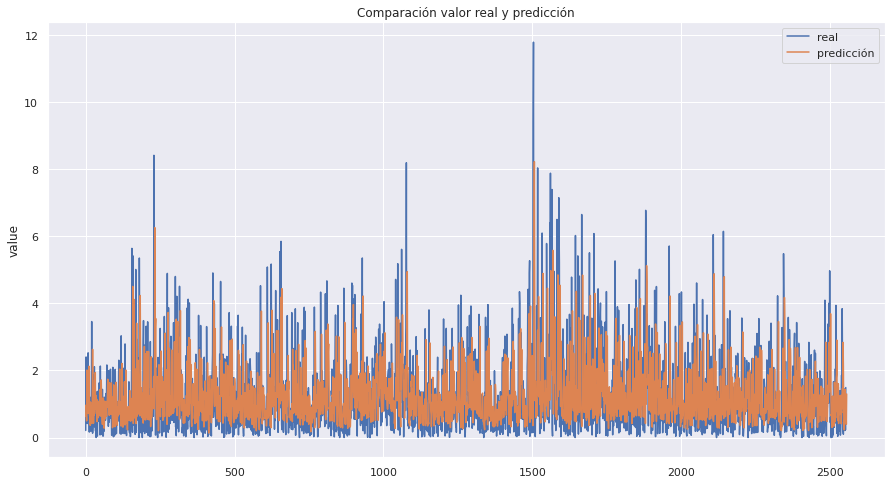

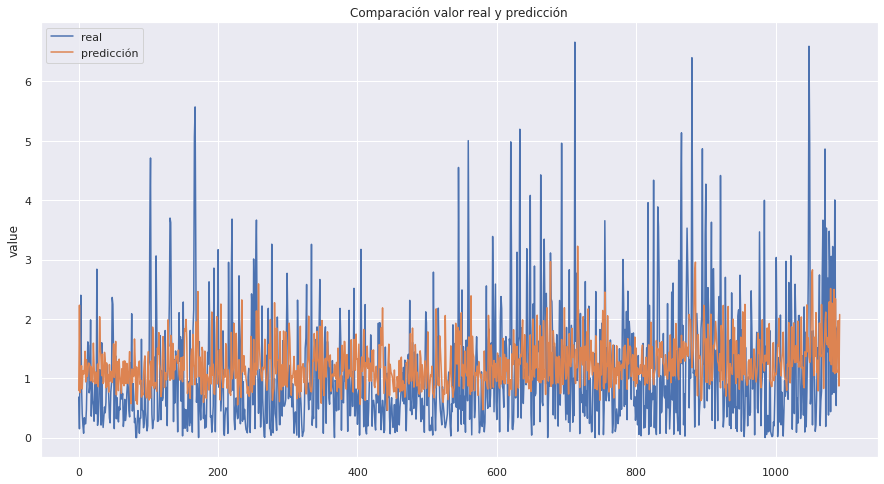

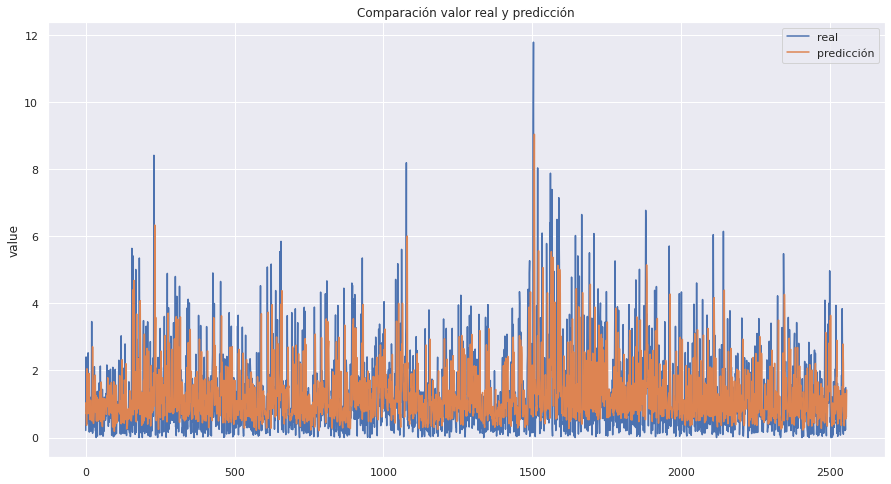

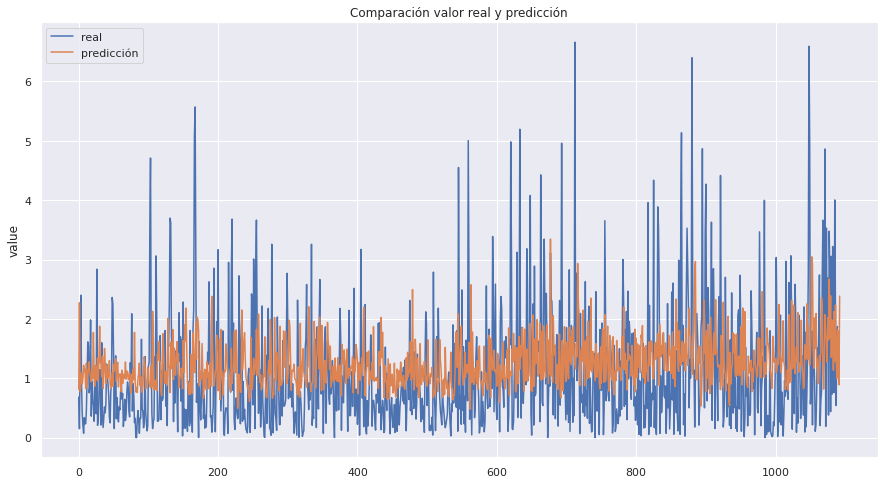

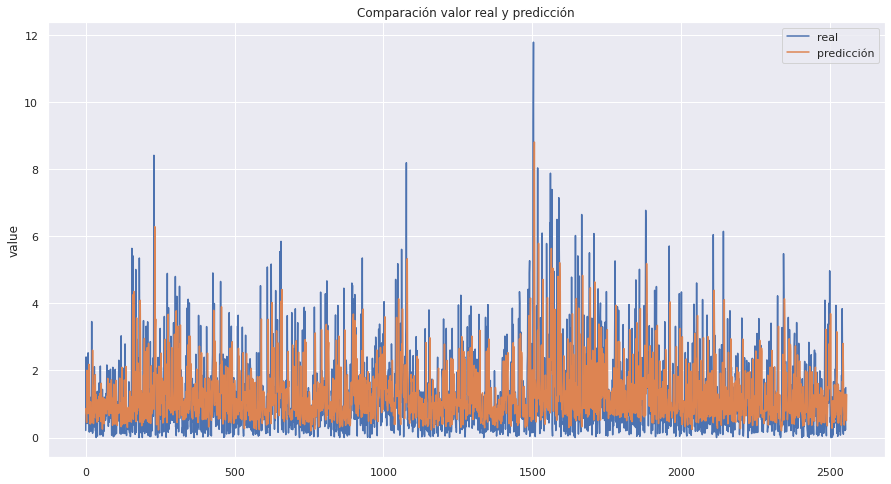

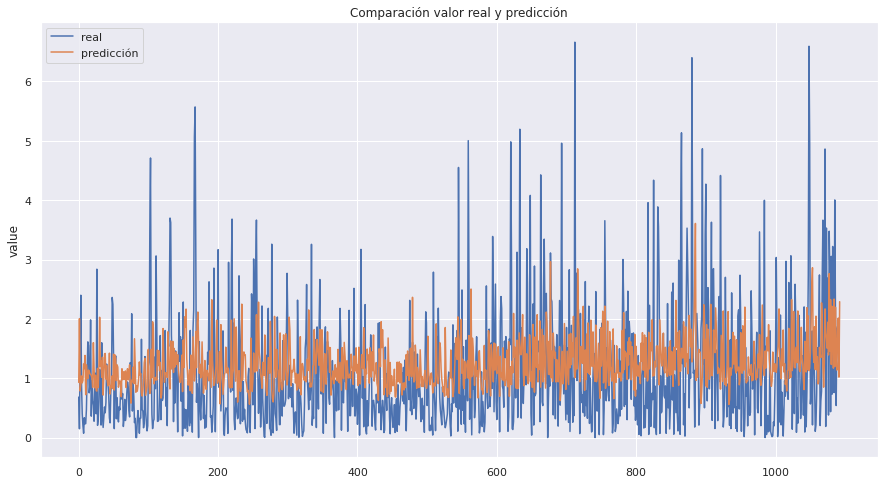

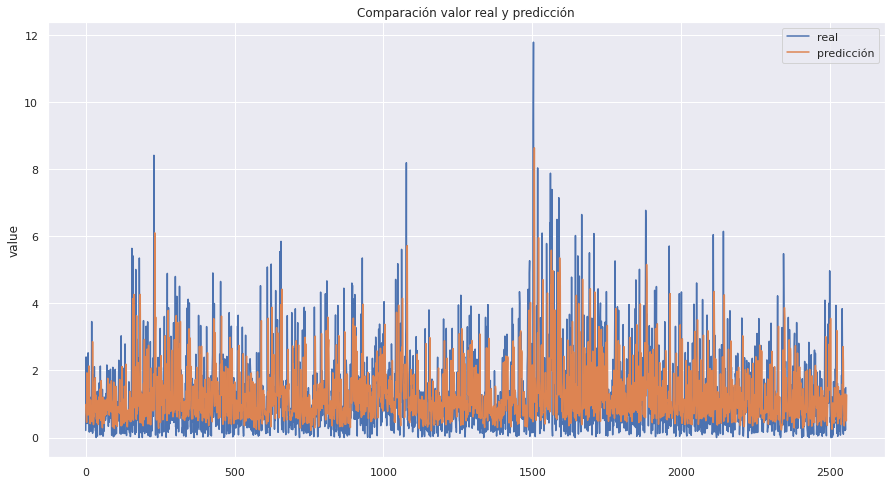

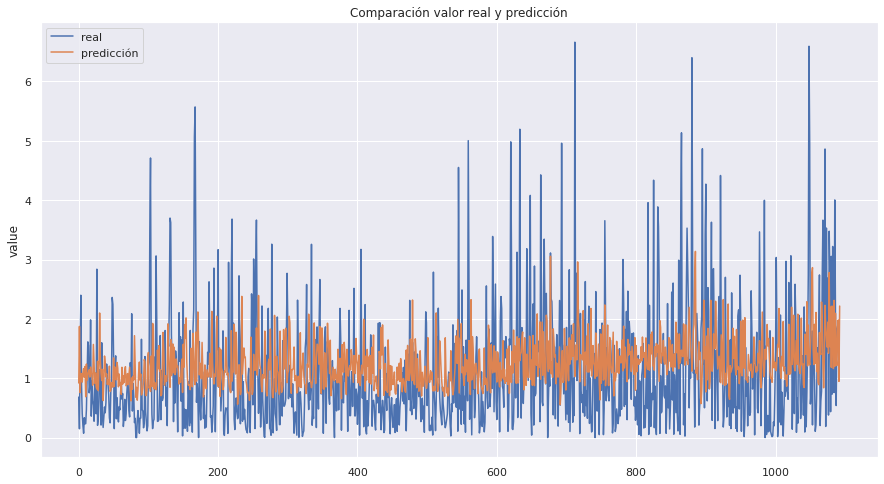

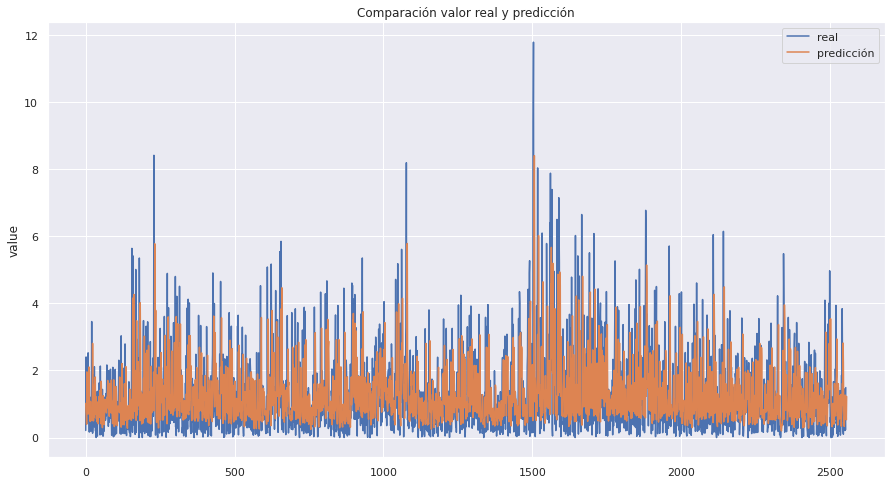

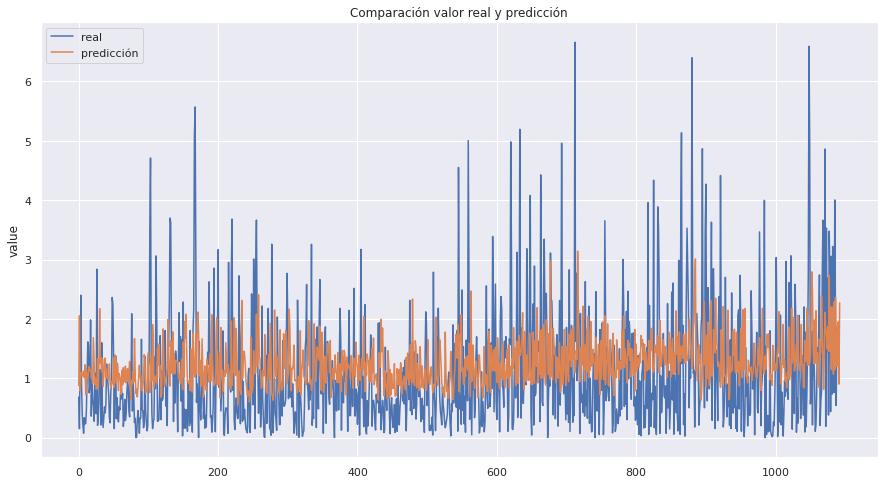

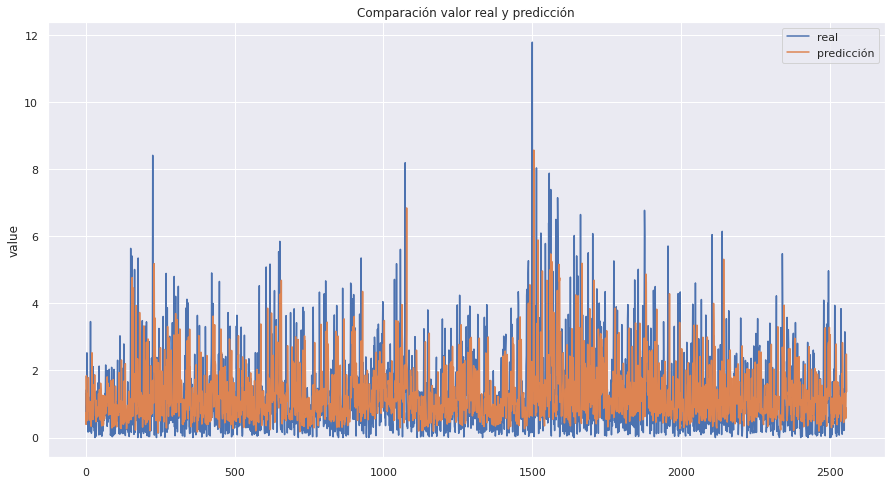

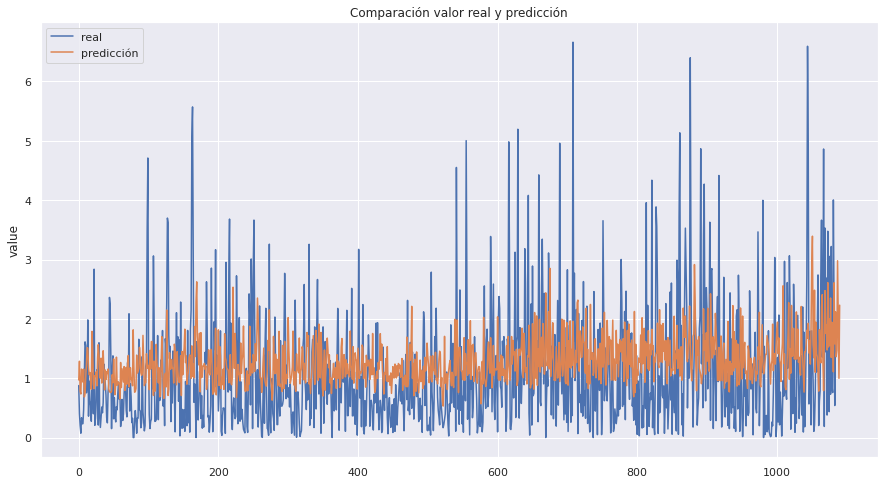

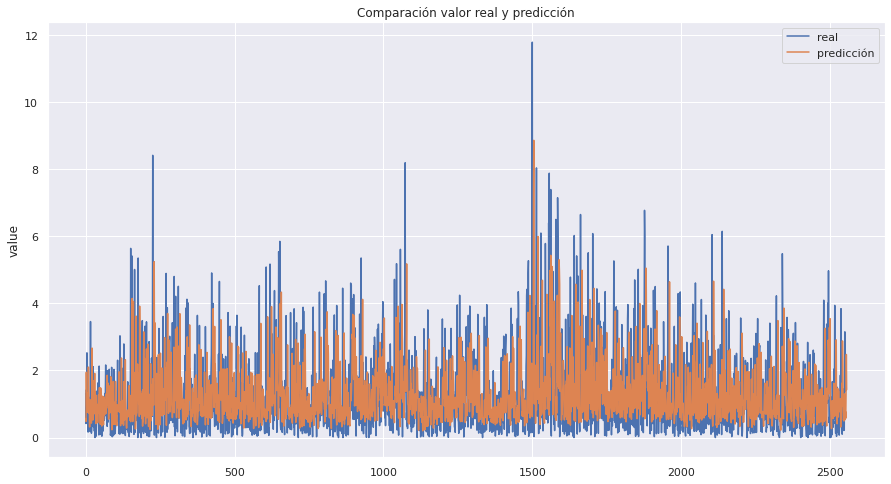

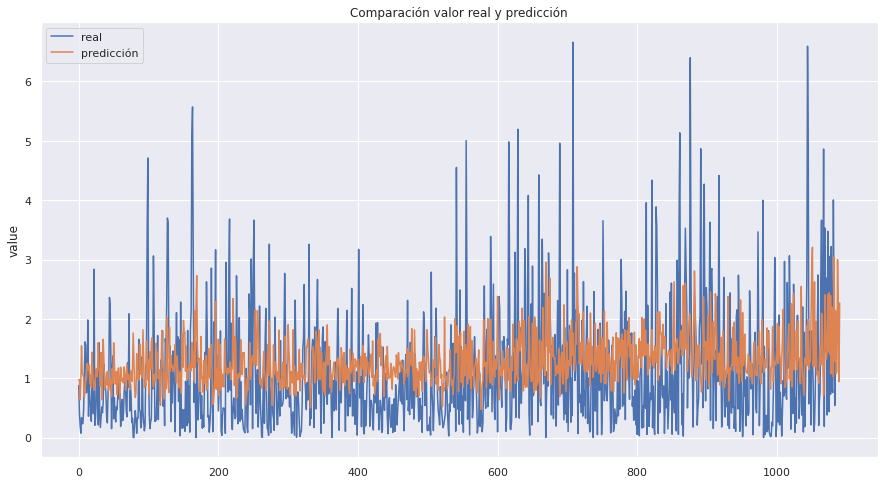

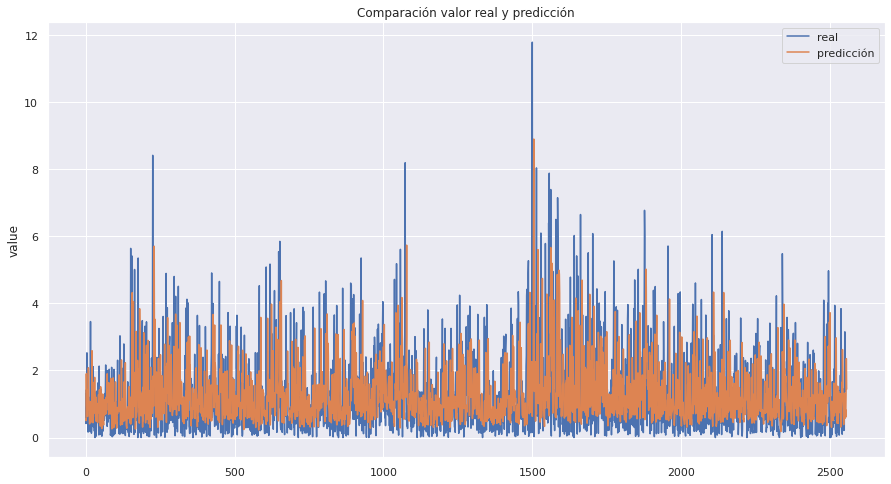

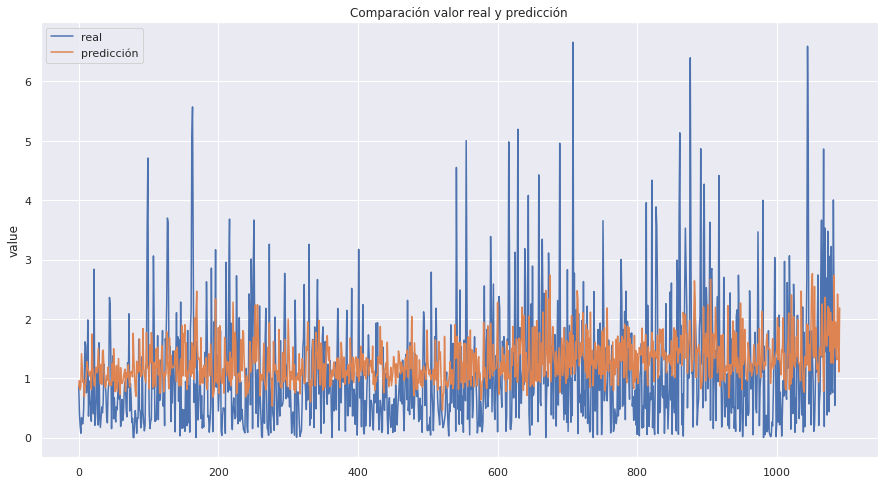

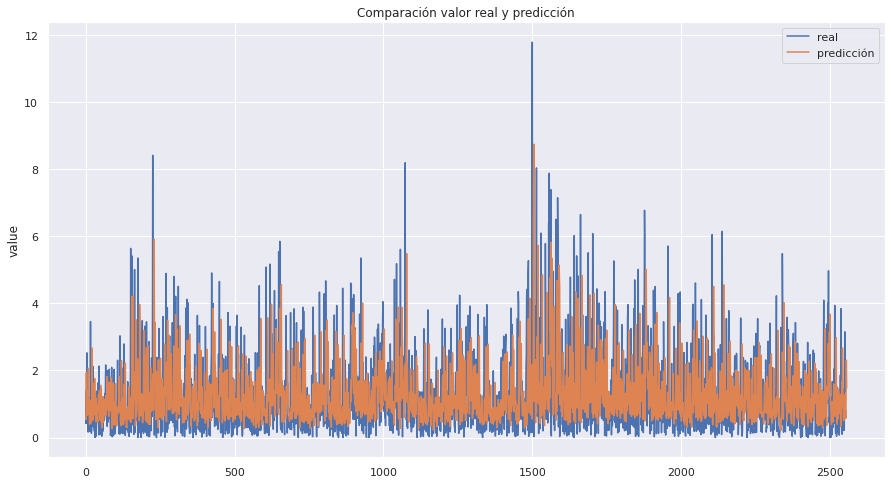

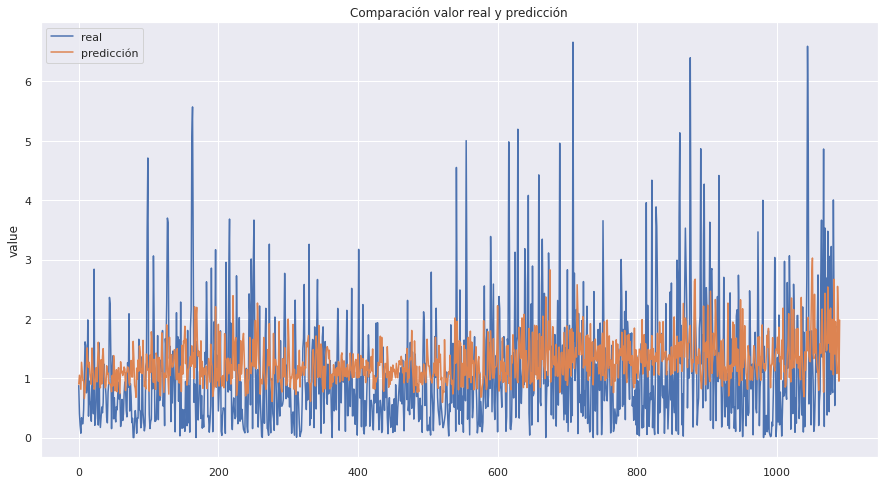

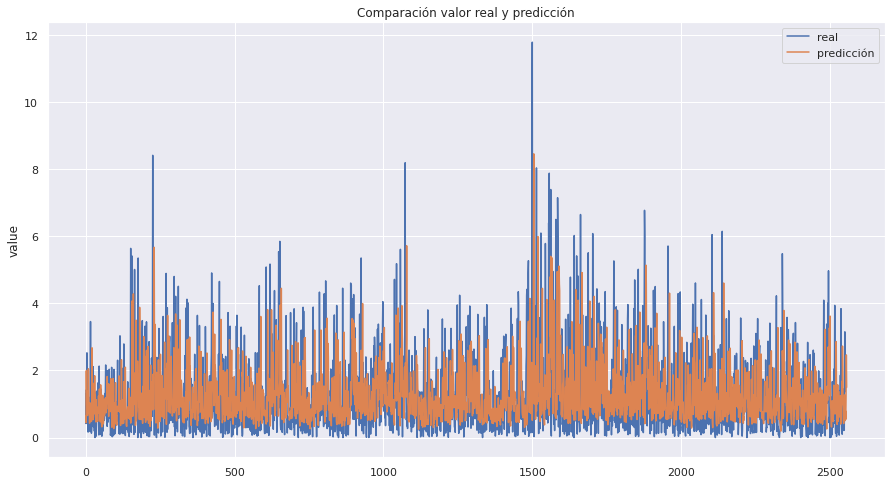

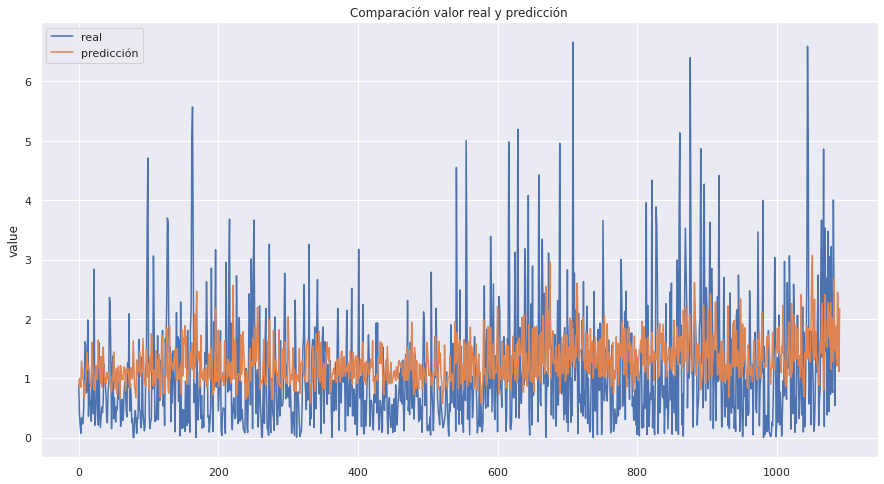

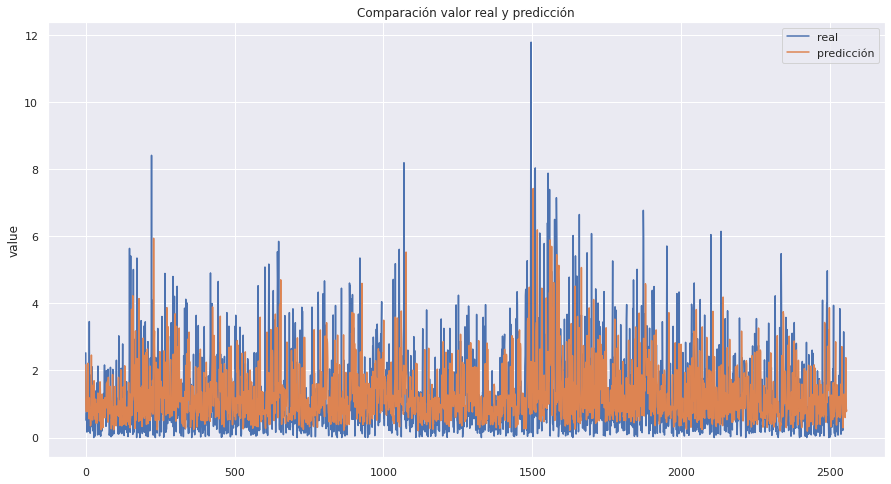

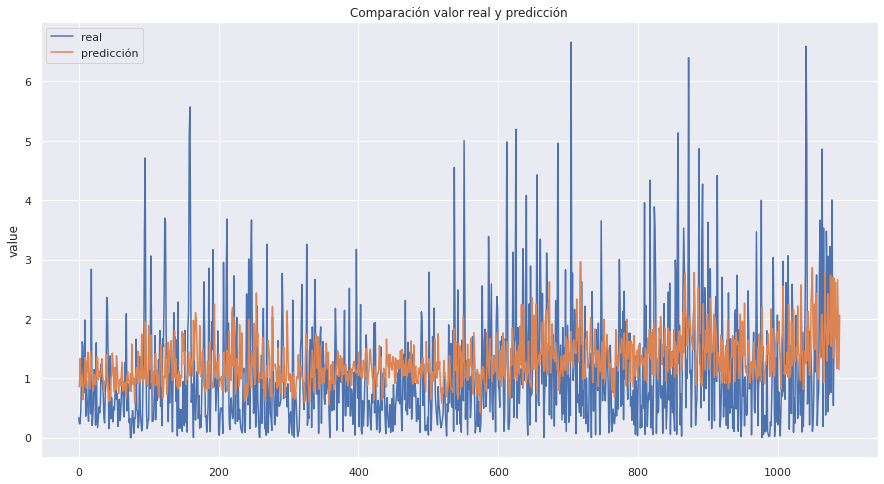

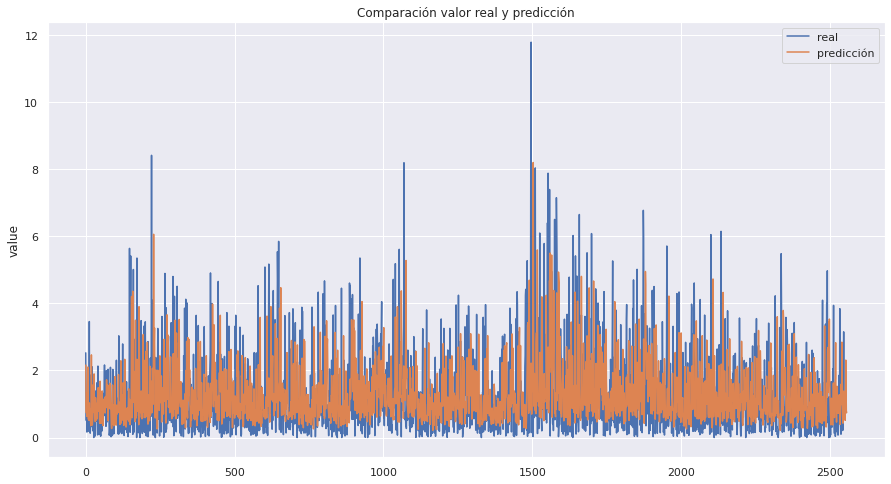

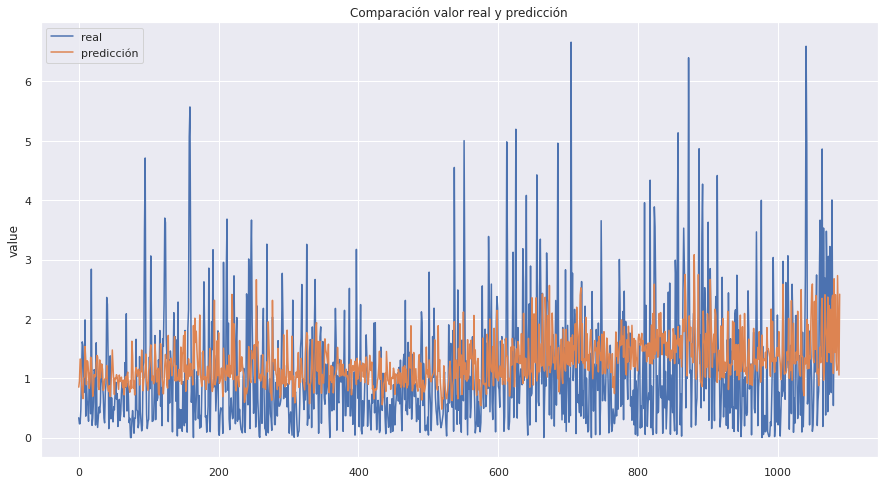

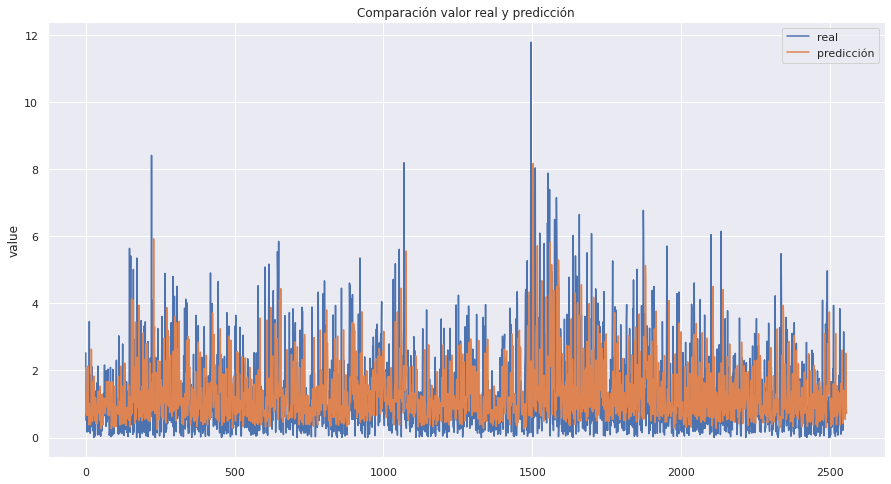

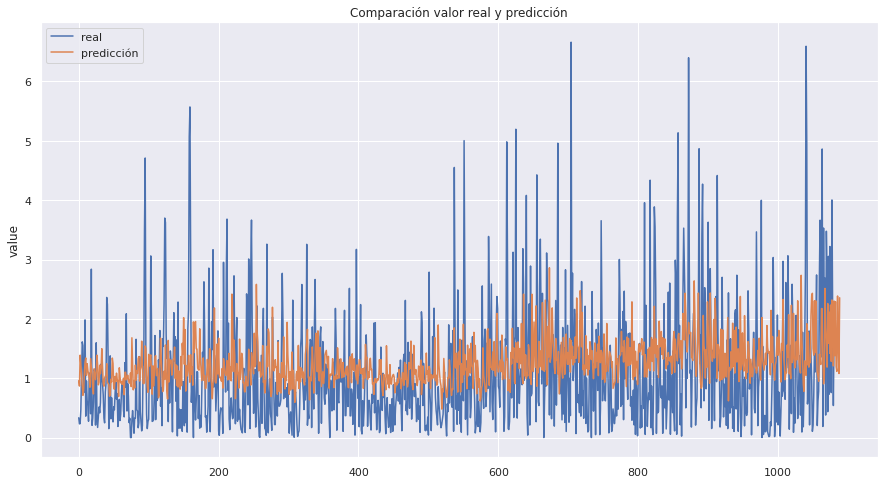

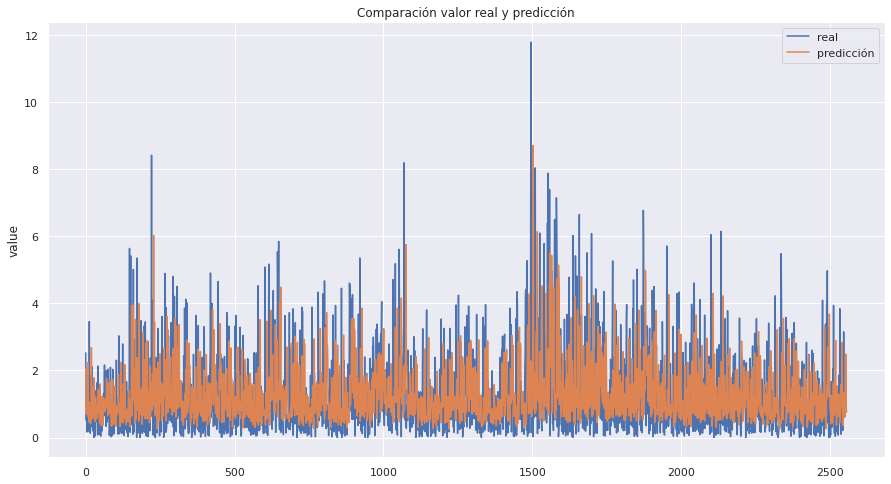

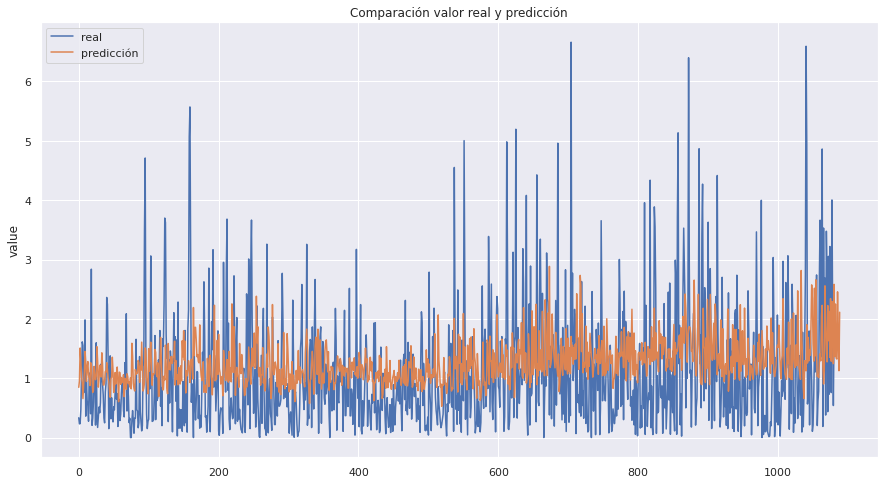

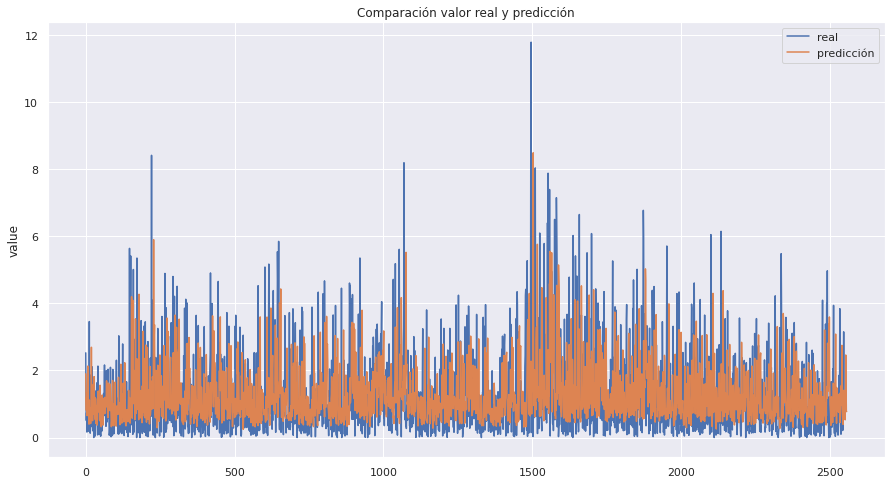

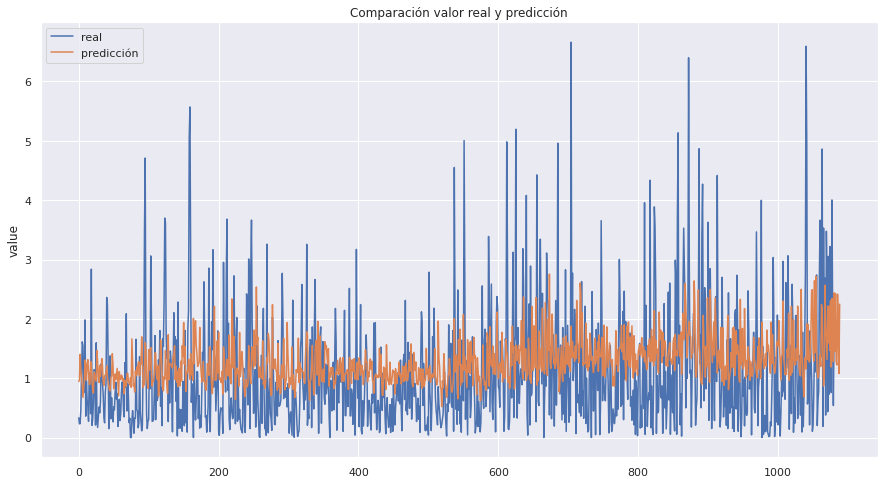

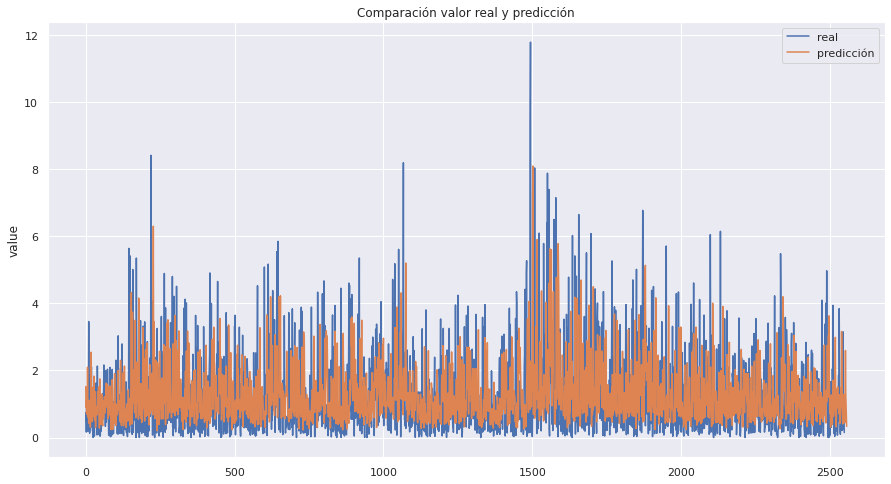

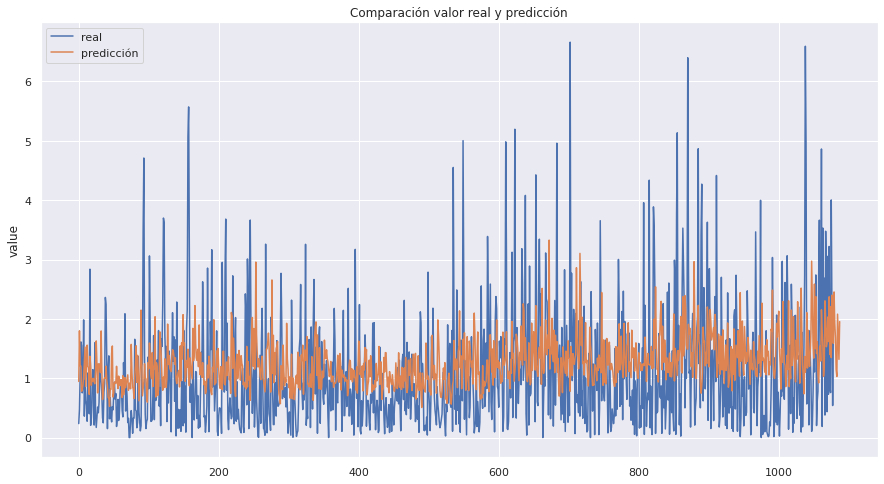

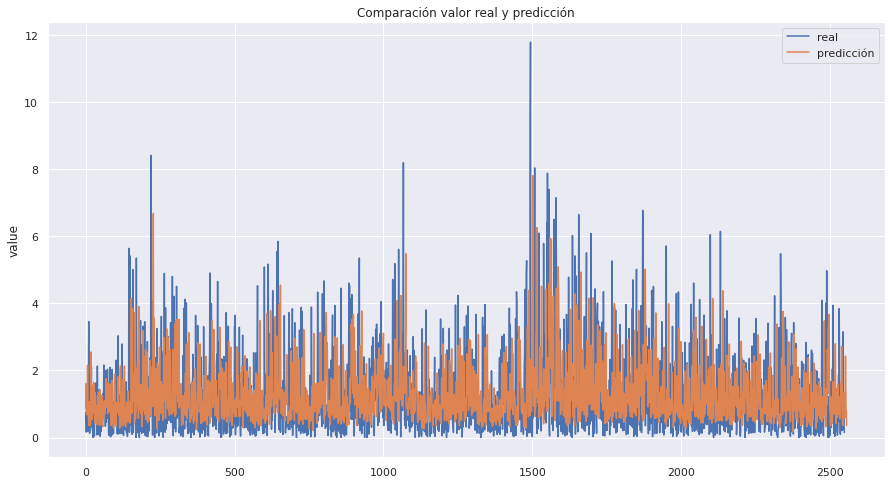

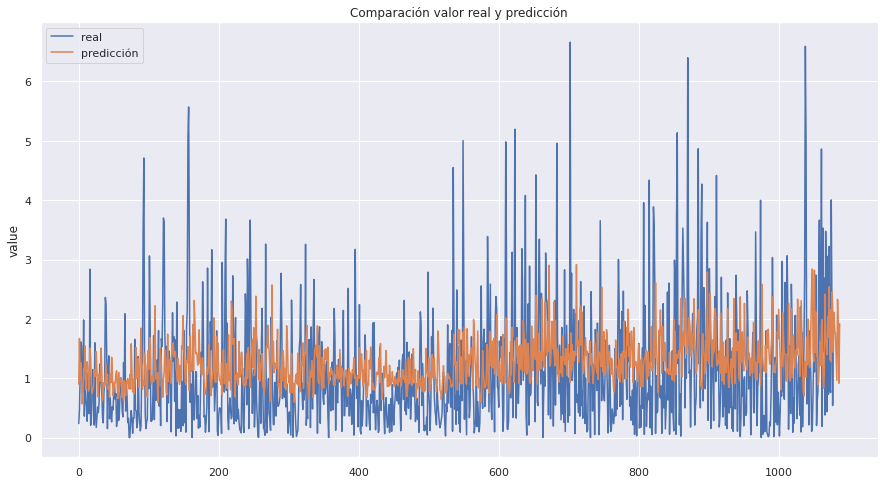

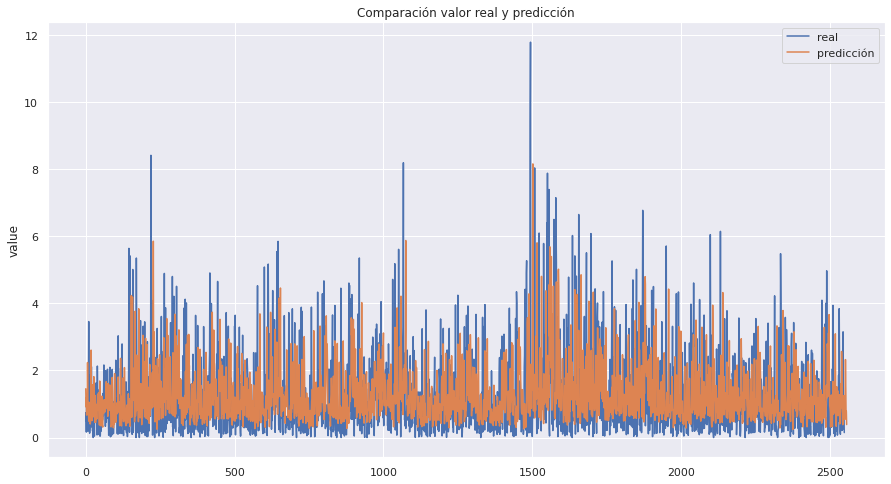

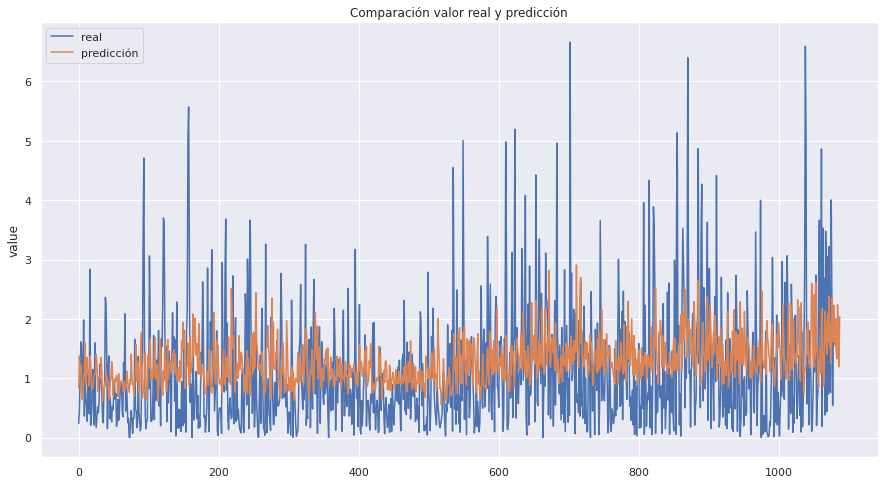

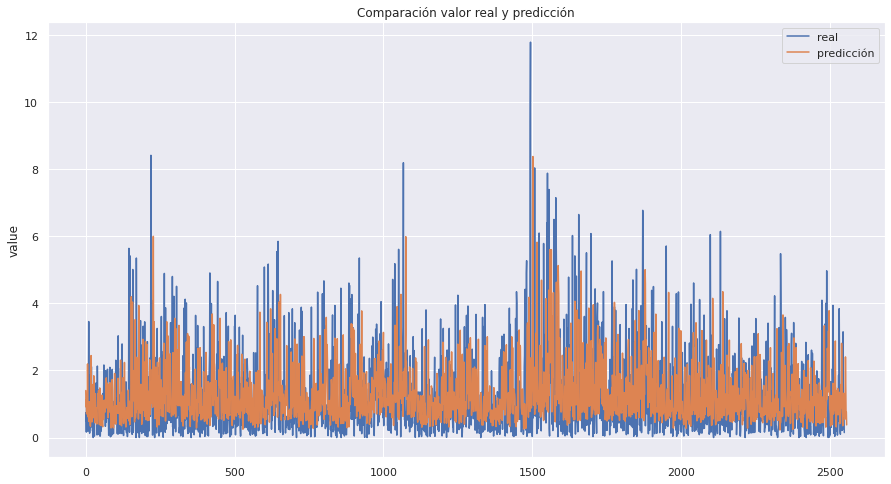

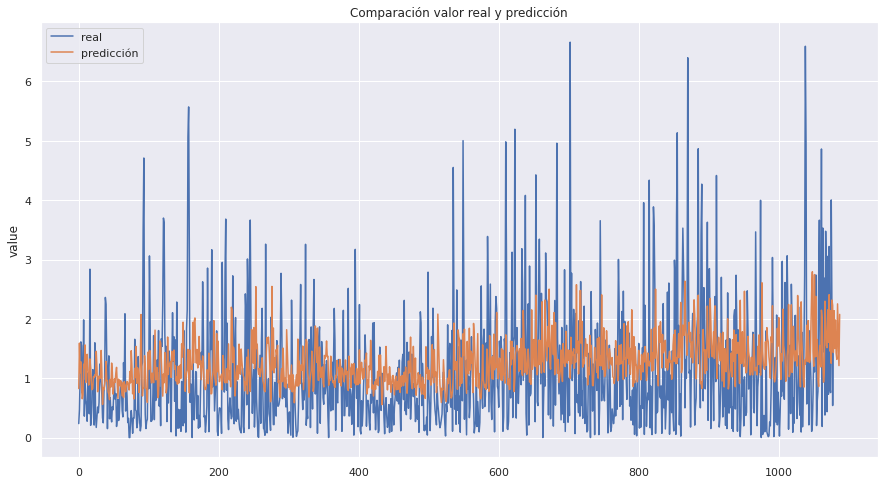

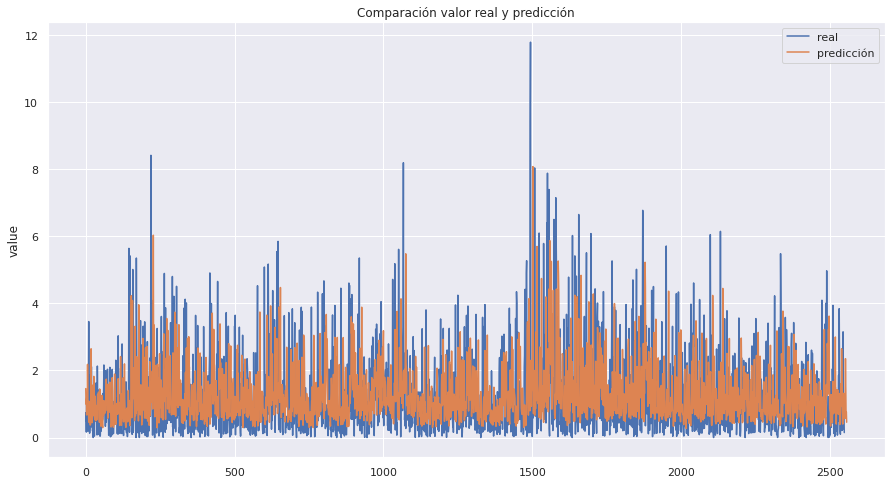

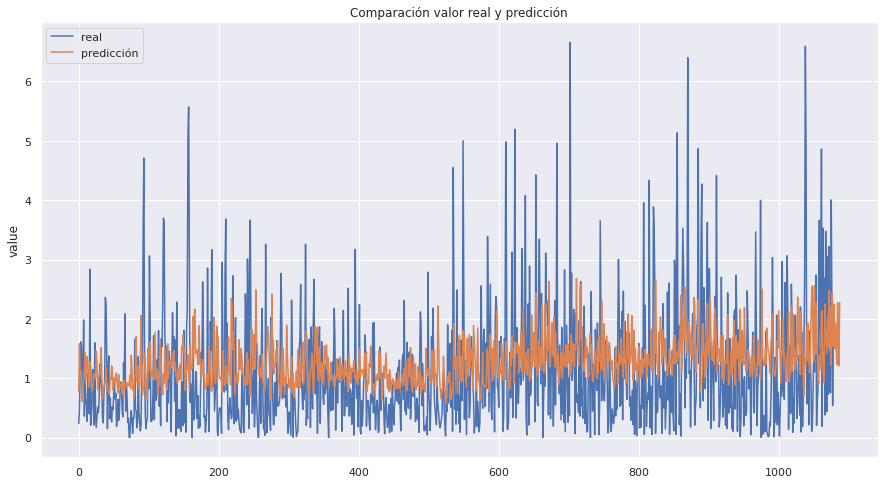

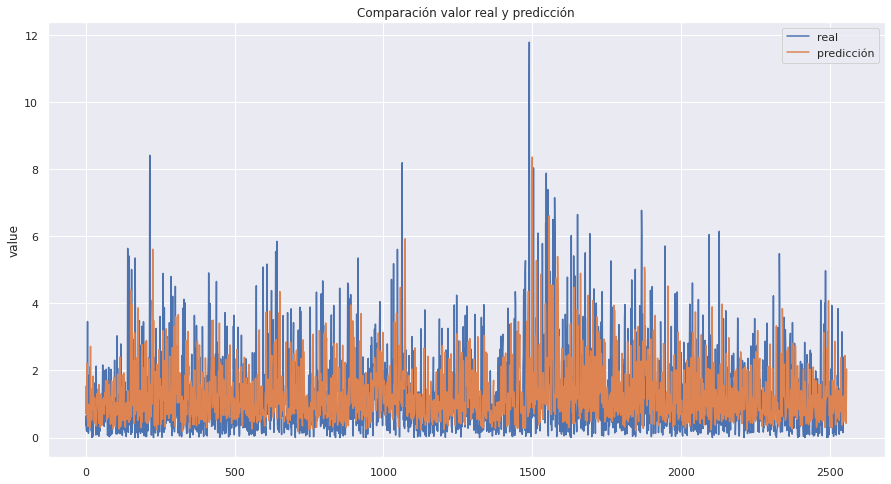

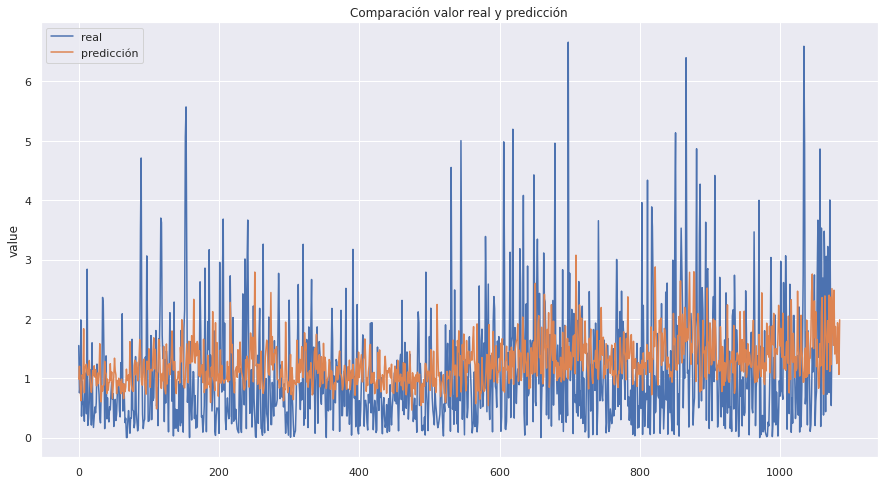

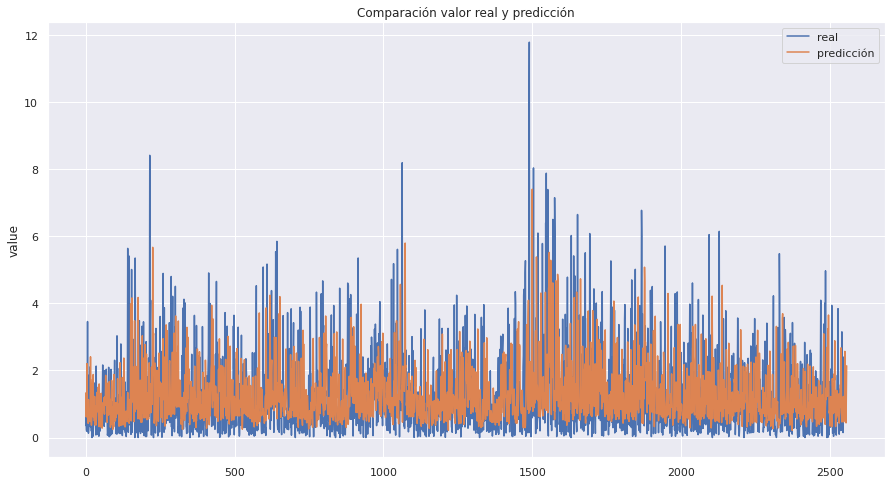

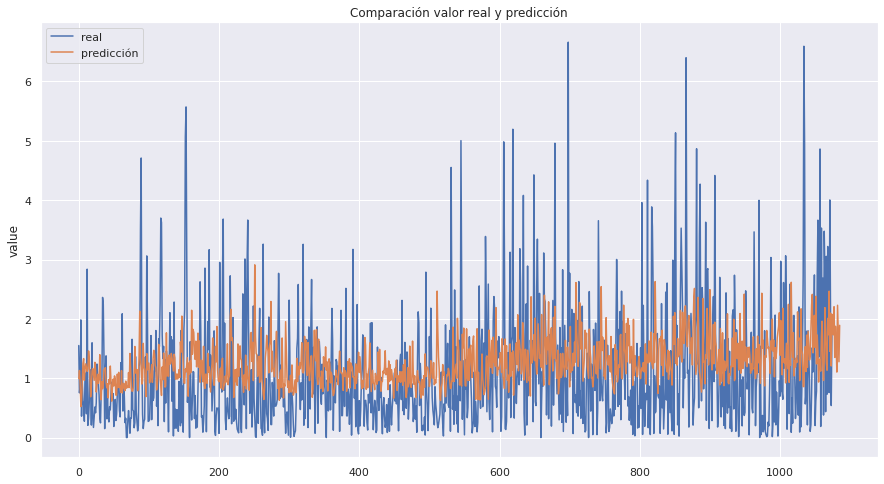

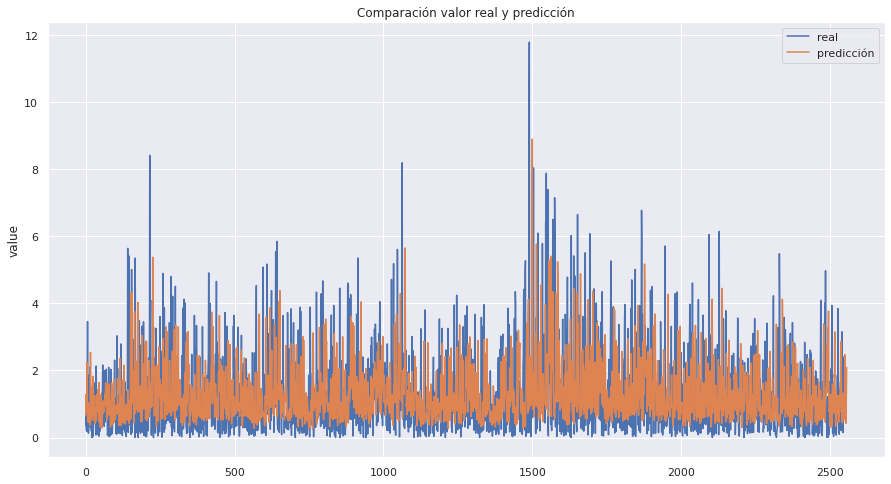

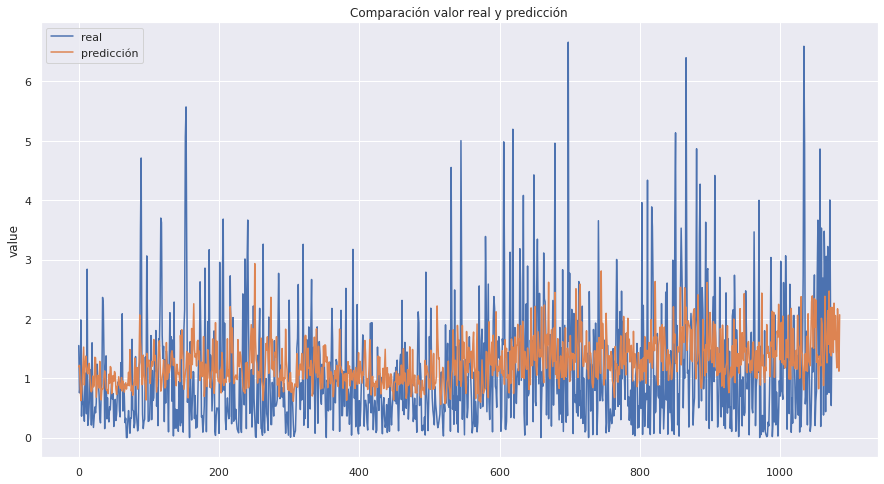

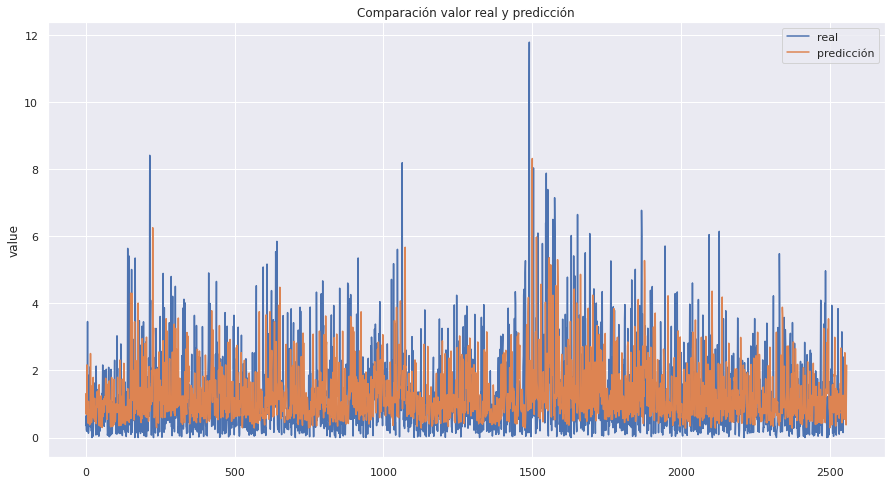

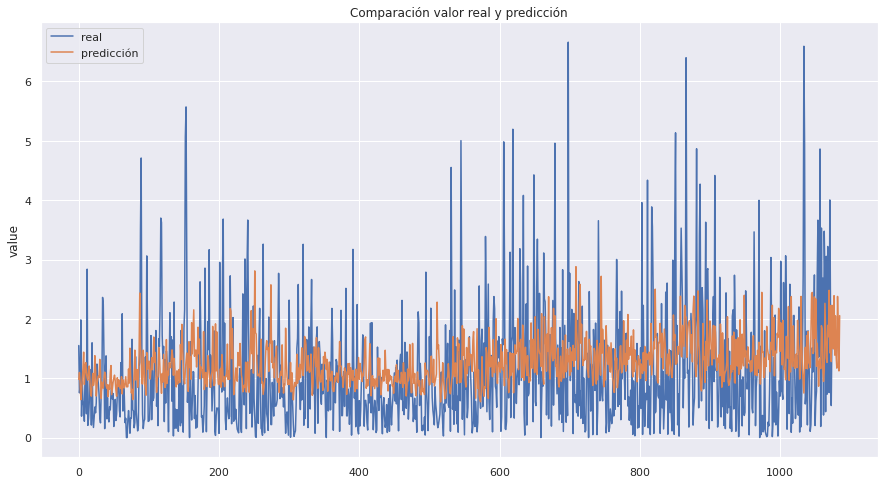

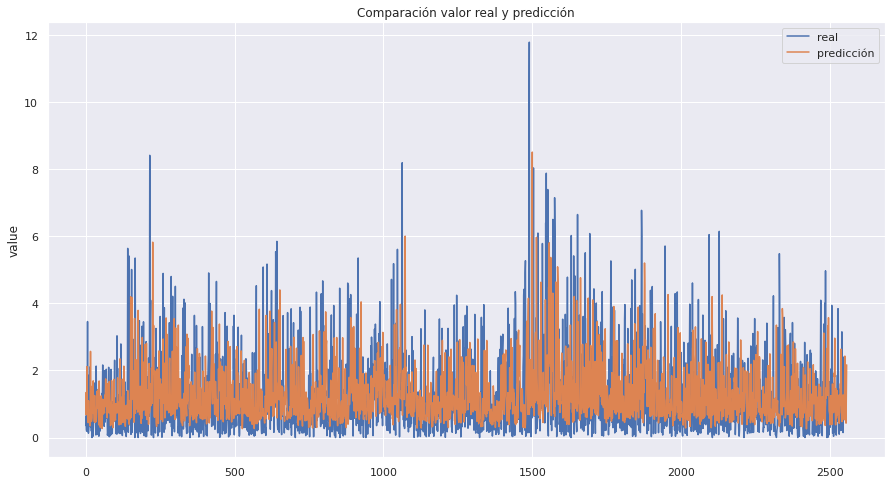

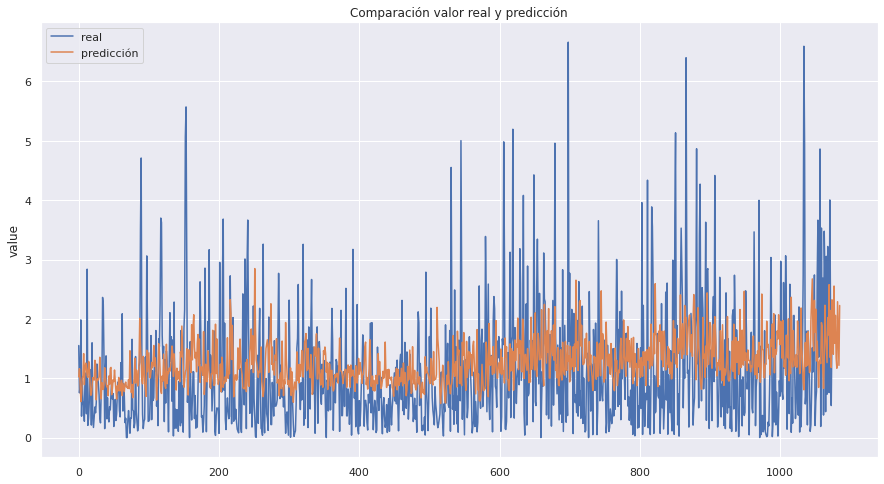

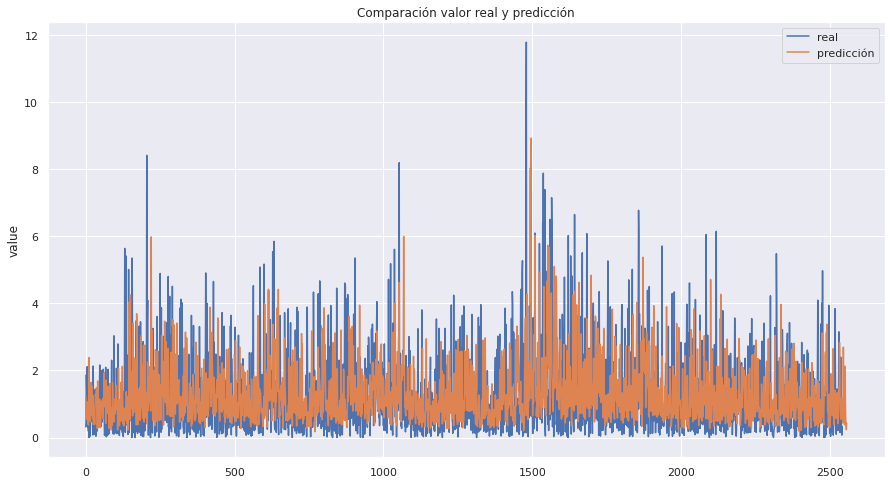

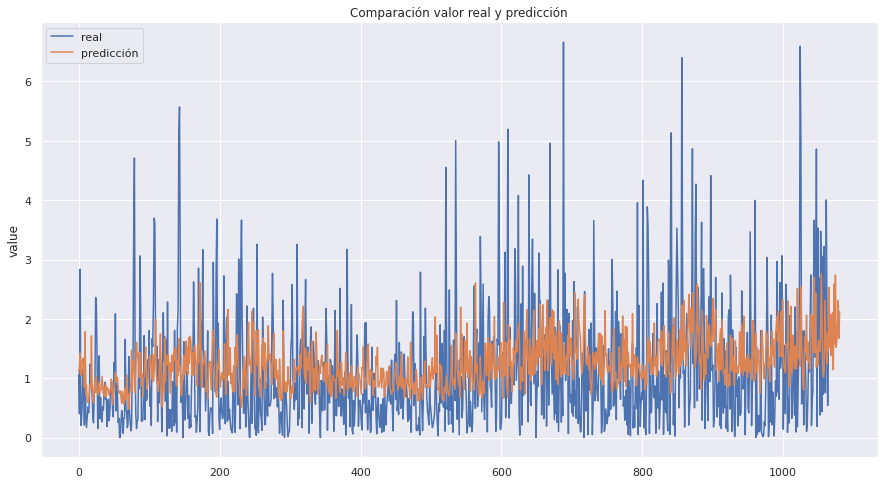

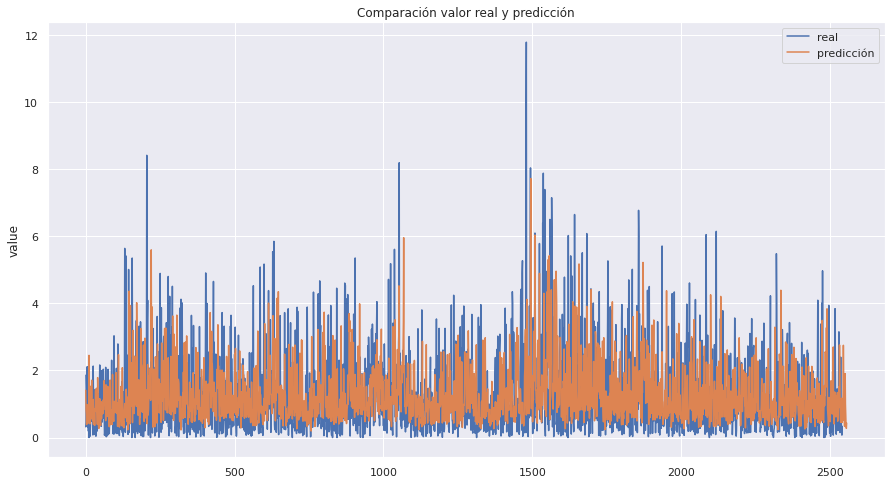

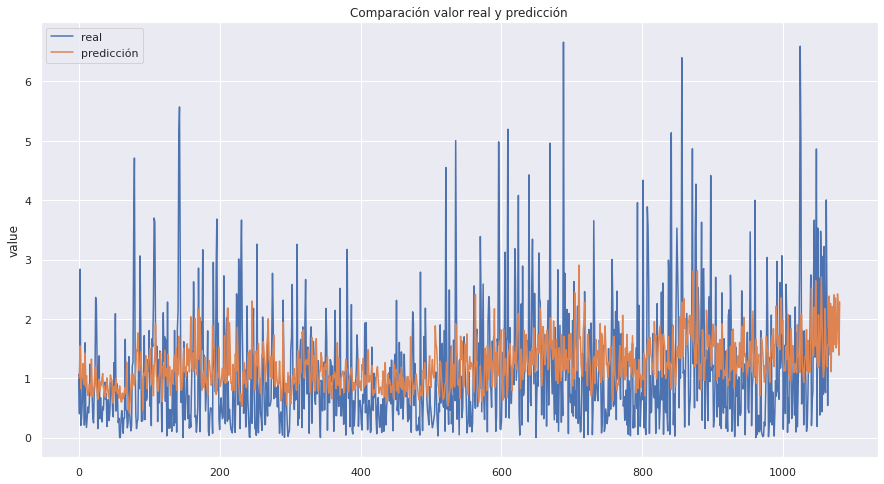

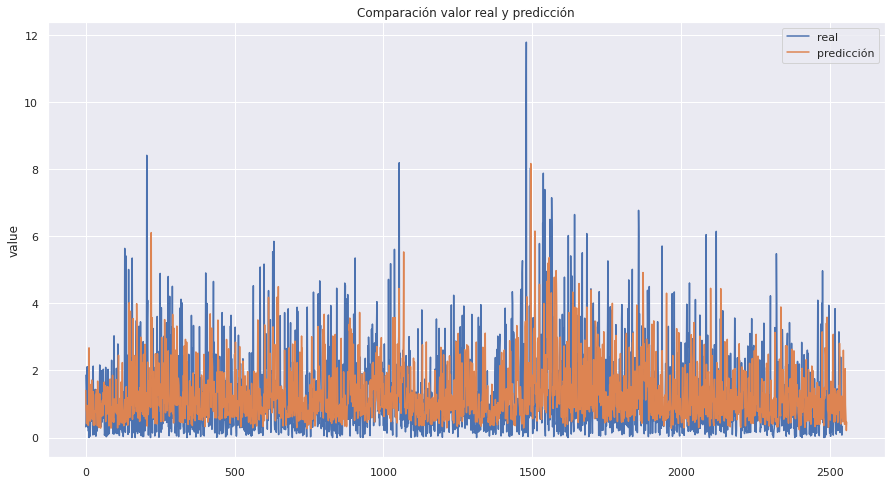

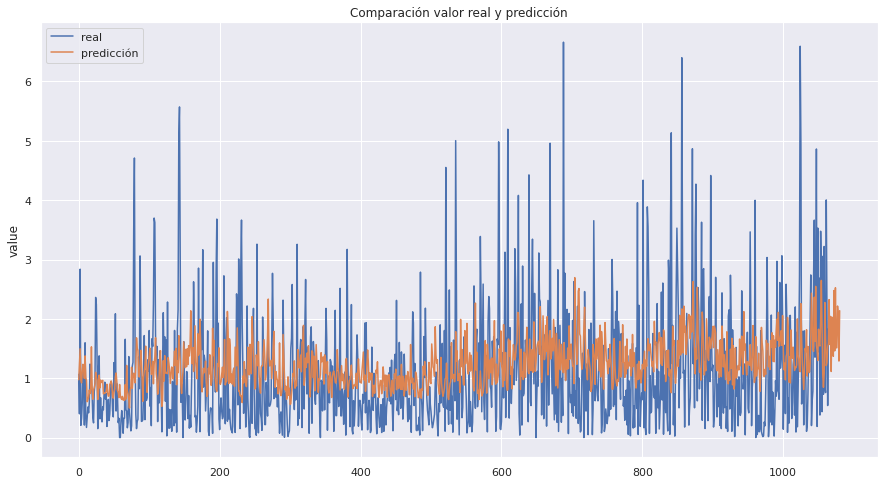

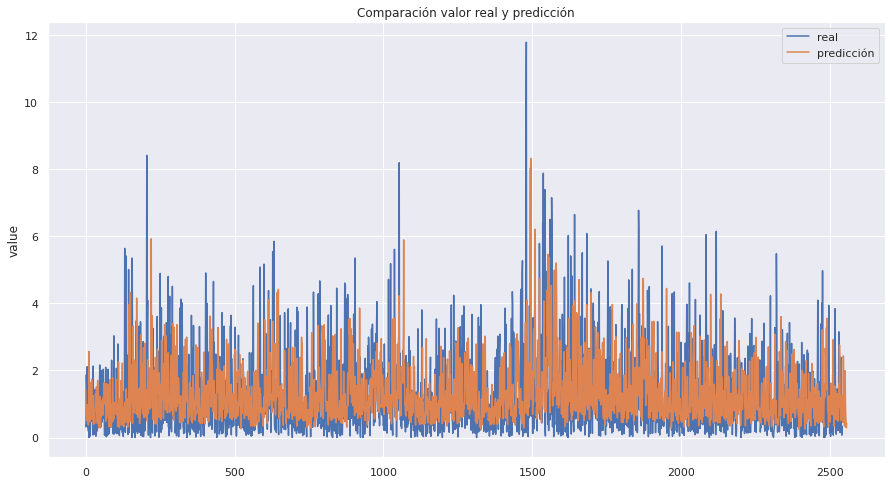

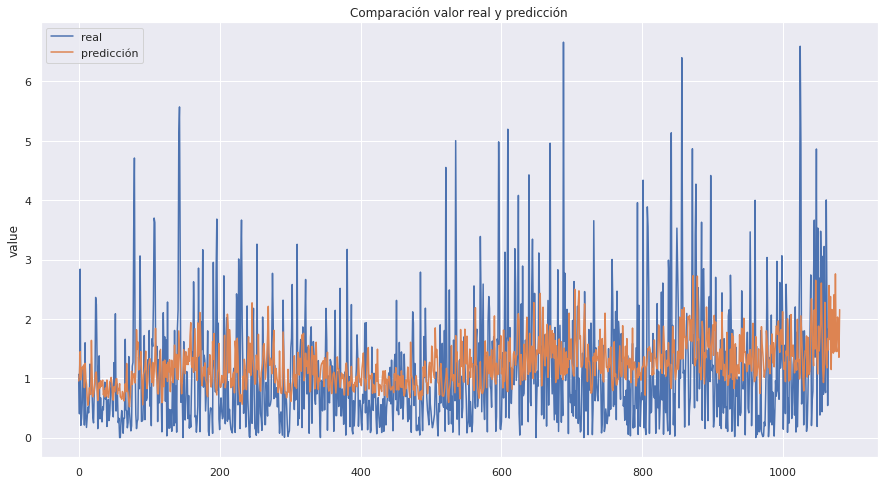

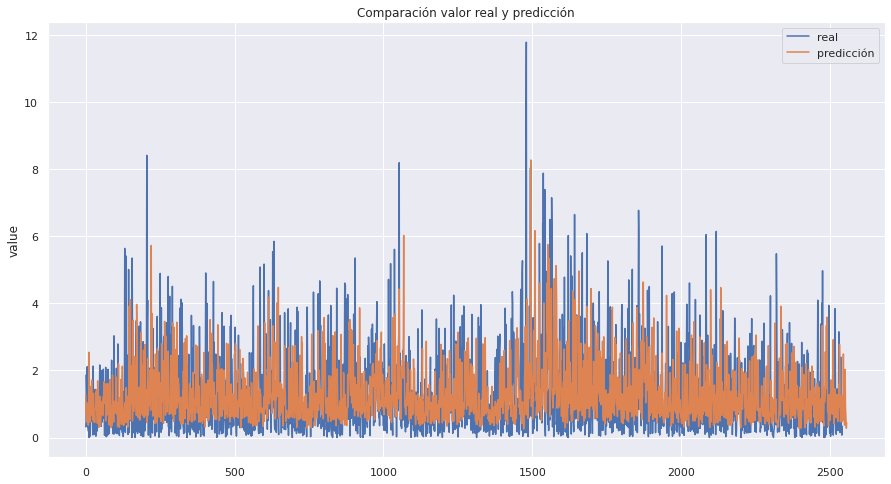

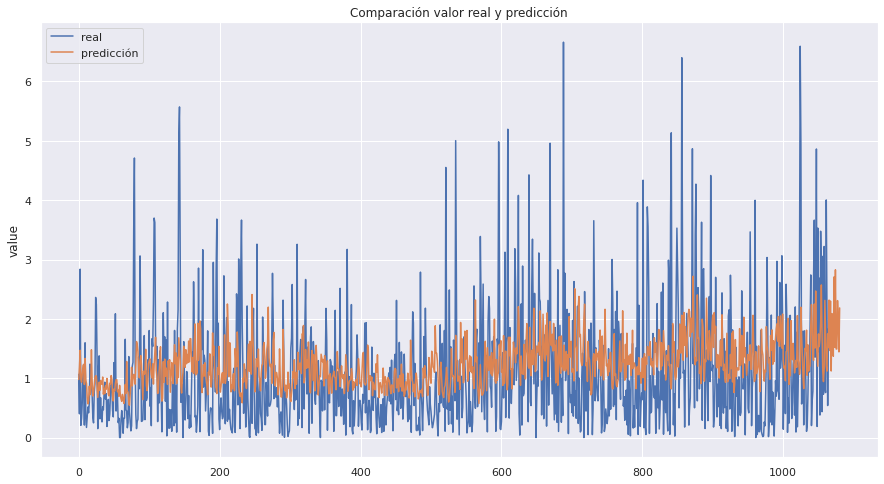

In [13]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)